# AIAP Batch 17 Technical Assessment
Name: Nicholas Daniel Phang Wei Li

## Objective
The problem statement given to us regards a rise in the number of scam calls in the year of 2023 resulting in S$651.8
million in financial losses. All this even as existing methods are already in place to prevent scam calls. 

As such, our aim is to develop an ML model for the telecommuncations company, that predicts and warns users that the call they are receiving is flagged as a potential scam call. We will do so by evaluating the effectiveness of various models to determine our best option. 

## Our Dataset
The dataset provided to us contains a list of attributes including the historical call data that have been labelled as scam and non-scam calls. As conveyed to us, there may be synthetic features in this dataset. 

## Approach
Our approach is as follows: 
1. We will first check through the dataset and understanding what type of information we are being handed. We should be able to reason out what type of values to expect and hence detect any anomalous values.

2. We will first check for any missing values to be replaced or imputed. This will depend on the context of our missing values. Given that we have attributes that are based on time and location, we could look into those attributes to attain group means of any missing values instead of using an overall mean.  

3. During our data cleaning stage, we will attempt to resolve any other anomalous values that we encounter. This could include negative values in positive-only attributes, or strings in all-integer columns etc. For columns containing strings with a mix of uppercase and lowercase, we will convert all entries to lowercase to anticipate the such inconsistencies during the addition of future datasets. 

4. After cleaning, we will convert our attributes into formats that are of more meaningful use to us in the later stages of analysis and model evaluation. This will include one-hot encoding, normalising, converting to numerical categories etc.  

5. Once all the data have been cleaned and formatted respectively, we will then determine which attributes may or may not be included in the further analysis or model training. As mentioned, there may be synthetic features in the dataset that may have value in inferring other attributes but may not bear as much of a predictive quality on our label. We will remove these along with any other intermediary columns created in the cleaning and formatting stage, essentially preparing the data for model training. 

6. Finally we will run a correlation across the features and run our dataset through various ML models to assess which model would work best in our scenario. 

## Base Imports for Exploratory Data Analysis
We start by importing the necessary packages for our analysis. We also import some modules from sklearn that we intend to use later on during our model evaluation.

In [1]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os 
import numpy as np
from datetime import datetime

print("packages imported")

packages imported


In [2]:
from sklearn import linear_model
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.naive_bayes import GaussianNB

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import f1_score

print("sklearn modules imported")

sklearn modules imported


### Connect to Database via SQLite 3
This code cell connects to the database file for us to construct our dataframe. 

In [3]:
# Connect to the SQLite database file
conn = sqlite3.connect('data/calls.db')
print("connected to database")

# Load data into a DataFrame using a SQL query
query = "SELECT * FROM calls"
df = pd.read_sql(query, conn)
print("dataframe set up")

# Close the database connection
conn.close()
print("connection to database now closed")

connected to database
dataframe set up
connection to database now closed


## Preliminary Overview of Dataset
Here we will run a few checks to get a rough overview of the dataset in question. 

### Shape of Dataset
Running .shape() gives us the dimensions of the dataframe. 

In [4]:
total_rows, total_columns = df.shape

print("Total number of rows:", total_rows)
print("Total number of columns:", total_columns)

Total number of rows: 12000
Total number of columns: 12


### Observe First 5 rows of the Dataset
To do this we run .head() to print the first 5 rows of the dataset. This gives us an actual peak into the values and what they look like. 

In [5]:
df.head()

,ID,Call Duration,Call Frequency,Financial Loss,Flagged by Carrier,Is International,Previous Contact Count,Country Prefix,Call Type,Timestamp,Device Battery,Scam Call
0,947429,-719,12,42.130000,Suspicious,Yes,1,95,Voip,2023-07-23 09:04:00,Fully Charged,Scam
1,540498,116,3,29.900000,Unlikely,Yes,0,91,Mobile,2023-09-05 20:11:00,Fully Charged,Scam
2,434243,29,16,723.460000,Very Suspicious,Yes,2,91,Voip,2023-12-16 11:03:00,Charging,Scam
3,903537,-563,4,64.287478,Unlikely,Yes,3,91,Telegram,2023-02-25 10:41:00,Fully Charged,Not Scam
4,969179,312,19,0.000000,Unlikely,Yes,0,91,Telegram,2023-11-10 15:53:00,Fully Charged,Scam


### Obtain Information on Attributes and Data Types Involved
Here we use .info() to identify certain information on each attribute in our dataframe. This includes the count of non-null values and the datatype of each attribute. 

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   ID                      12000 non-null  int64  
 1   Call Duration           12000 non-null  int64  
 2   Call Frequency          12000 non-null  int64  
 3   Financial Loss          10597 non-null  float64
 4   Flagged by Carrier      12000 non-null  object 
 5   Is International        12000 non-null  object 
 6   Previous Contact Count  12000 non-null  int64  
 7   Country Prefix          12000 non-null  object 
 8   Call Type               12000 non-null  object 
 9   Timestamp               12000 non-null  object 
 10  Device Battery          12000 non-null  object 
 11  Scam Call               12000 non-null  object 
dtypes: float64(1), int64(4), object(7)
memory usage: 1.1+ MB


### Check Count of NaN Values in Dataset
Through .info() we can notice that there are missing values in the 'Financial Loss' column. Let us run a count of .isnull() values on the 'Financial Loss' to verify this. 

In [7]:
# Sum of missing values (if any)
print("Missing values:")
print(df.isnull().sum())

Missing values:
ID                           0
Call Duration                0
Call Frequency               0
Financial Loss            1403
Flagged by Carrier           0
Is International             0
Previous Contact Count       0
Country Prefix               0
Call Type                    0
Timestamp                    0
Device Battery               0
Scam Call                    0
dtype: int64


<Axes: >

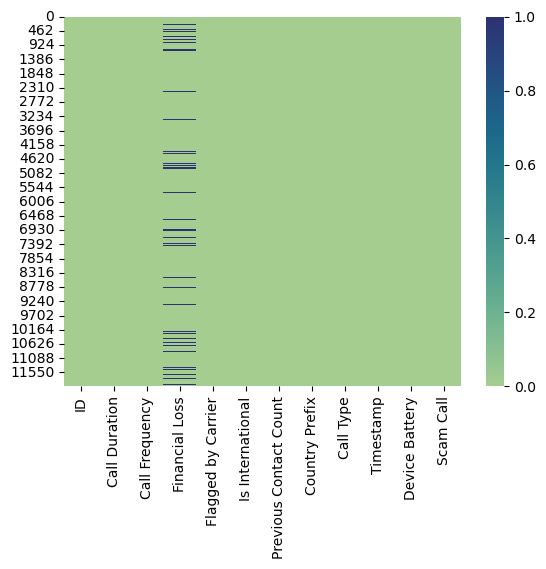

In [8]:
sns.heatmap(df.isna(),cmap = 'crest')

The NaN values seem to be scattered throughout our dataset. We will have to look into this later in detail. 

### Produce a Statistical Summary of the Dataset
Running .describe() on our dataframe allows us to quickly get the statistics of all our numerical columns. 

In [9]:
# Summary statistics
print("\nSummary statistics:")
print(df.describe()) 


Summary statistics:
                  ID  Call Duration  Call Frequency  Financial Loss  \
count   12000.000000   12000.000000    12000.000000    10597.000000   
mean   551248.413500     100.259417       10.698167       95.128864   
std    257920.330881     288.006415        5.861791      191.516365   
min    100017.000000    -787.000000        2.000000     -896.400000   
25%    332326.250000     -30.000000        6.000000        0.000000   
50%    545820.000000      45.000000        9.000000       11.719081   
75%    776049.250000     282.000000       15.000000       84.264405   
max    999709.000000     822.000000       27.000000     1055.440000   

       Previous Contact Count  
count            12000.000000  
mean                 1.861167  
std                  1.765310  
min                  0.000000  
25%                  0.000000  
50%                  2.000000  
75%                  3.000000  
max                  8.000000  


### Overview of Attributes
Following the attribute description table as provided, here are some initial insights about each attribute.

We have a total of 12000 call cases recorded in the dataset, each with 12 attributes of information. This forms a dataframe of 12000 rows by 12 columns. 

1. ID (int) - A unique identifier used by the telecommunications company to identify the call/case while maintaining anonymity. 

2. Call Duration (int): -787(min) to 822 (max) - Total duration of the call in seconds. This should contain positive integers only, though through running describe() we have noted negative values in this column.

3. Call Frequency (int): 2(min) to 27(max) - Essentially the frequency of outgoing calls over a 24hr period from the caller in each logged case. This contains positive integers, might be worth investigating the correlation between a higher frequency and higher likeliness of the call being a scam. 

4. Financial Loss (float): -896.40(min) to 1055.44(max) - Amount of money reported stolen by the receiver. This should contain positive values but describe() has also highlighted negative values in this column. We also have NaN values in this column that will be addressed later. 

5. Flagged by Carrier (object): -  Whether the caller number was flagged by the carrier as suspicious before. This column should contain a categorical object based on how suspicious the call is deemed to be. Perhaps this can be used as a benchmark for the trained model, or it can be used as a training feature to build upon pre-existing scam identification methods. 

6. Is International (object): - This column should be an object with two possible categories on whether the call was an international call or not. 

7. Previous Contact Count (int): 0(min) to 8(max) - Number of times the caller has called the same receiver before. This could indicate a long-running scam, but it could indicate a contact who is known by the receiver?

8. Country Prefix (object): - Country code where the call is originating from. This should be in adherence to international subscriber dialing (ISD) standards. Column does not seem to inclue the "+" before the prefix which is good. 

9. Call Type (object): - The medium on which the call was made, i.e. whether the call was made on a landline or a messaging app like Telegram. 

10. Timestamp (object): - The date and time when the call was made, the values seem to be formatted as YYYY-MM-DD hh:mm:ss. This attribute could aid us in understanding the trends of other attributes or the label over time, perhaps from month to month. 

11. Device Battery (object): - The battery status of the caller’s device, which could be an indicator of the device being a part of a scam/bot farm which typically have racks of mobile devices that are all plugged into their respective chargers. We should be expecting categories on whether the device is charging at the time of the call or not. 

12. Scam Call (object): - Indicating if the call is a Scam or Not Scam. This attribute is the label that we are trying to predict in this problem. It is possible that this attribute was manually labelled based on customer reports/complaints, and thus it is worth being cautious on the possibility of wrong labelling due to human error. 


## Attributes in Detail and Data Cleanup
Now that we have an overview of the entire dataset we will dive deeper into each attribute, investigating and cleaning each attribute if we identify any issues with the values. We will also transform the attributes where necessary to prepare them for use in our models. 

### Define Checking Functions
Listed below are some functions that we will use to help us check the various attributes. 

In [10]:
# Count the number of negative entries in column
def negative_count(df, col_name):
    num_negative = (df[col_name] < 0).sum()
    print("Number of negative", col_name, ":", num_negative)
    
# Count the number of negative entries AND zero in column
def zero_and_negative_count(df, col_name):
    num_negative = (df[col_name] <= 0).sum()
    print("Number of zero and negative", col_name, ":", num_negative)
    
def check_A_B_values(df, col_name, replacement_values):
    # Check if all values are either 'A' or 'B'
    if all(value in replacement_values for value in df[col_name].astype(str)):
        print(col_name + ": " + f"all values are '{replacement_values[0]}' or '{replacement_values[1]}'")
    else:
        # Count the number of values that are not 'A' or 'B'
        count_not_yes_no = sum(1 for value in df[col_name].astype(str) if value not in replacement_values)
        print(col_name + ": " + f"{count_not_yes_no} values are not all '{replacement_values[0]}' or '{replacement_values[1]}'")
        
        # Display unique values that are not 'A' or 'B'
        unique_values_not_yes_no = set(df[col_name].astype(str)) - set(replacement_values)
        print(col_name + ": " + f"Unique values not '{replacement_values[0]}' or '{replacement_values[1]}':", unique_values_not_yes_no)
        
print('Checking functions defined')

Checking functions defined


### 1. Scam Call
We shall start with 'Scam Call' as this is our label or our target attribute. We should be expecting values in this column to fall into a binary category of 'Scam' or 'Not Scam'. First, we will check if this is indeed so. 

In [11]:
# Converting all to lowercase
df['Scam Call'] = df['Scam Call'].str.lower()

check_A_B_values(df, 'Scam Call', ['scam', 'not scam'])

Scam Call: all values are 'scam' or 'not scam'


Now that we have verified this, we will convert the categories into a numerical binary. 

In [12]:
df['Scam Call'] = df['Scam Call'].replace('not scam', 0)
df['Scam Call'] = df['Scam Call'].replace('scam', 1)
df['Scam Call'] = df['Scam Call'].astype(int)

In [13]:
df['Scam Call'].head()

0    1
1    1
2    1
3    0
4    1
Name: Scam Call, dtype: int32

In [14]:
# Count occurrences of 'Scam' in the label
scam_count = (df['Scam Call'] == 1).sum()

print("Count of 'Scam' entries in the 'Scam Call' column:", scam_count)

# Calculate percentage
total_rows = len(df)
percentage_scam = (scam_count / total_rows) * 100

print("Percentage of 'Scam' entries in the dataframe:", percentage_scam)

Count of 'Scam' entries in the 'Scam Call' column: 4446
Percentage of 'Scam' entries in the dataframe: 37.05


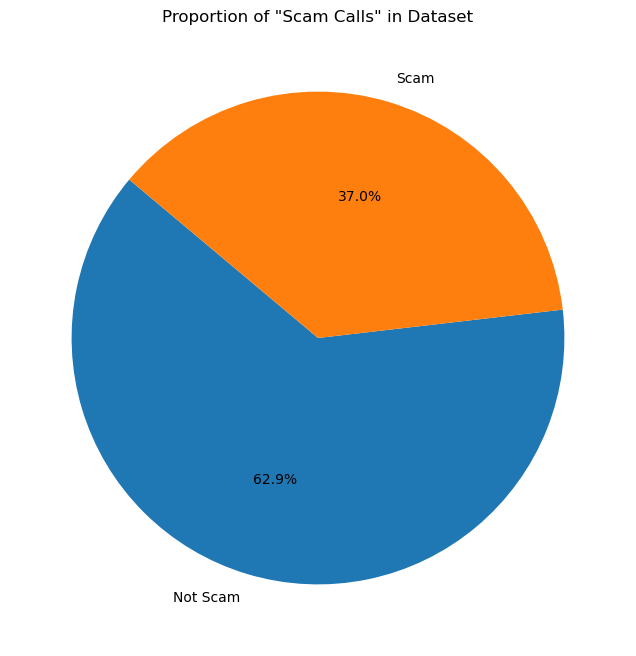

In [15]:
counts = df['Scam Call'].value_counts()
pie_label = ['Not Scam', 'Scam']

plt.figure(figsize=(8, 8)) 
plt.pie(counts, labels=pie_label, autopct='%1.1f%%', startangle=140)
plt.title('Proportion of "Scam Calls" in Dataset')
plt.show()

### 2. Call Duration
For this column as mentioned above, we are expecting a positive-only integer that represents the call duration in seconds. We know from .describe() that there are likely several negative values in the column (implied from the min and 25%  values). Let us determine the total count of negative values. 

In [16]:
# Count the number of zero and negative entries in the Call Duration
zero_and_negative_count(df, 'Call Duration')
negative_count(df, 'Call Duration')

Number of zero and negative Call Duration : 3344
Number of negative Call Duration : 3344


The check highlights that there are 3344 negative values in this column (they are non-0 as both checks return the same count). This which makes up roughly 25% of the total rows, which is a too high a proportion to omit from the dataset. 

However, despite the incorrect polarity of these values, the magnitudes still fall within a reasonable range (minimum of -787s). It is reasonable to account for these negative values as being due to typographical errors. Therefore, we will fix these values by using abs() to obtain the absolute of the values. 

In [17]:
df['Call Duration'] = df['Call Duration'].abs()
negative_count(df, 'Call Duration')

Number of negative Call Duration : 0


All negative values have been resolved through .abs(), meaning we maintain the magnitude of these entries while reversing the polarity. Now, we will categorise the data into equally-spaced buckets using pd.cut() as the values are continuous. 

In [18]:
# Cut the values into binned categories (300s = 5mins, 600s = 10mins, 900s = 15mins)
df['Call Duration Category'] = pd.cut(df['Call Duration'], bins = [0, 300, 600, 900])

# Convert the categories into numbered categories where short calls = 0, medium calls = 1, long calls = 2
df['Call Duration Category Numerical'] = pd.factorize(df['Call Duration Category'])[0]

In [19]:
# Display the value counts of the numerical categories
df['Call Duration Category Numerical'].value_counts()

Call Duration Category Numerical
1    8524
2    2293
0    1183
Name: count, dtype: int64

Text(0.5, 1.0, 'Number of Short, Medium, and Long Calls')

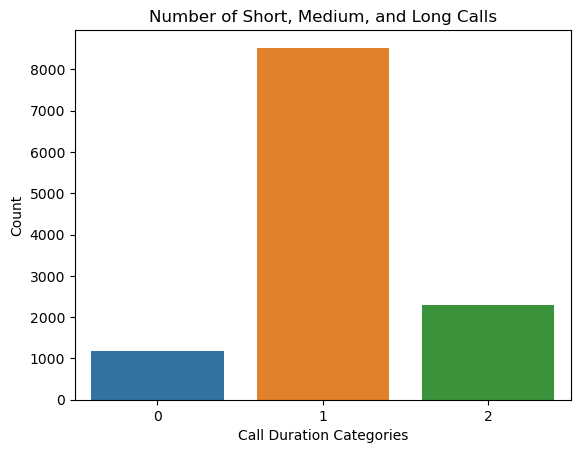

In [20]:
#sns.countplot(x=df['Call Duration Category Numerical'], hue='Scam Call', data=df, order=[0, 1, 2])
sns.countplot(x=df['Call Duration Category Numerical'], data=df, order=[0, 1, 2])

plt.xlabel('Call Duration Categories')
plt.ylabel('Count')
plt.title('Number of Short, Medium, and Long Calls')

Now we are left with three categories, representing different lengths of call duration - short, medium, and long calls. It seems most of the calls in our dataset fall into the 'medium call' category (between 300s to 600s, or between 5mins to 10mins). 

While the duration of the call can only be fully determined once the call is ended, this can still be considered an indicative attribute. Our preventative measure (an SMS to the user) can be triggered if a call crosses a certain duration of time given that other indicative conditions are met. Therefore it is worth factoring this attribute into our model. 

### 3. Call Frequency
Our 'Call Frequency' values are positive integers ranging from 2 to 27. We will also bin these values into categories. 

In [21]:
# Similarly we bin the frequency of calls into low, medium, and high
df['Call Frequency Category'] = pd.cut(df['Call Frequency'], bins = [0, 10, 20, 30])
df['Call Frequency Category Numerical'] = pd.factorize(df['Call Frequency Category'])[0]

In [22]:
df['Call Frequency Category Numerical'].value_counts()

Call Frequency Category Numerical
1    6882
0    4319
2     799
Name: count, dtype: int64

Text(0.5, 1.0, 'Categorised Frequency of Calls Made by Caller')

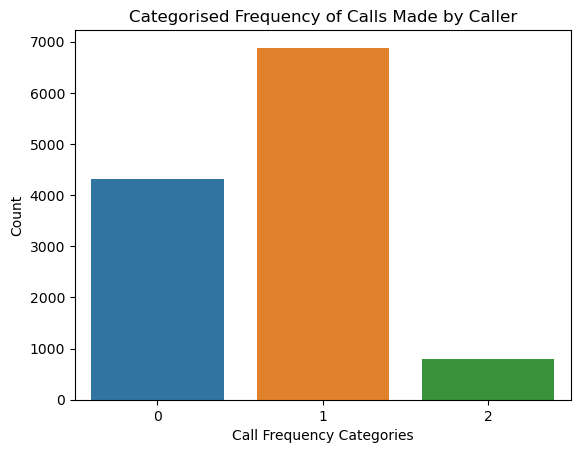

In [23]:
sns.countplot(x=df['Call Frequency Category Numerical'], data=df, order=[0, 1, 2])

plt.xlabel('Call Frequency Categories')
plt.ylabel('Count')
plt.title('Categorised Frequency of Calls Made by Caller')

Here we have 3 categories of how many outgoing calls the caller has made in the past 24h window from the time the call was logged. As we can see, most callers in the dataset made a medium amount of calls (between 10 to 20 calls). 

### 4. Flagged By Carrier
This column should contain categorical objects denoting the "suspicion" level of the call as deemed by the carrier. First, let us check how many unique categories exist in the column. 

In [24]:
# Converting all to lowercase
df['Flagged by Carrier'] = df['Flagged by Carrier'].str.lower()

unique_carrier_flags = sorted(df['Flagged by Carrier'].unique())

# Create a dictionary see all unique categories in 'Flagged by Carrier'
flagged_by_carrier_map = {carrier_flag: i for i, carrier_flag in enumerate(unique_carrier_flags)}

print(flagged_by_carrier_map)

{'suspicious': 0, 'unlikely': 1, 'very suspicious': 2}


The 'Flagged by Carrier' column contains a total of 3 unique values - suspicious, unlikely, and very suspicious. We can use this column later as a benchmark against our models' performance in predictive ability. Before we proceed, let's convert this column into numbered categories through one-hot encoding. 

In [25]:
# Rearrange the order to represent ordinal characteristics properly
flagged_by_carrier_ascending_map = {'unlikely': 0, 'suspicious': 1, 'very suspicious': 2}

df['Flagged by Carrier'] = df['Flagged by Carrier'].map(flagged_by_carrier_ascending_map)

df['Flagged by Carrier'].value_counts()

Flagged by Carrier
0    9104
1    1666
2    1230
Name: count, dtype: int64

It is worth noting that although this represents the carrier's own existing method of highlighting a scam call, we can include this in our analysis and model evaluation by logic of 'building upon' existing scam identification means. However we do have to recognise that in doing so, we may be incorporating any inherent biases that may exist in the carrier's scam identification procedure, and we do not have enough information to determine what this might consist of. 

Additionally, we can also use this as a benchmark during a later stage when we evaluate our models.

### 5. Is International
This column should contain two categories of objects - Yes or No. We will verify this first, before converting our binary categories into a numerical binary feature. 

In [26]:
# Converting all to lowercase
df['Is International'] = df['Is International'].str.lower()

# Check for 'Is International' column
check_A_B_values(df, 'Is International', ['yes', 'no'])

Is International: all values are 'yes' or 'no'


In [27]:
df['Is International'] = df['Is International'].replace('no', 0)
df['Is International'] = df['Is International'].replace('yes', 1)
df['Is International'] = df['Is International'].astype(int)
df['Is International'].head()

0    1
1    1
2    1
3    1
4    1
Name: Is International, dtype: int32

Given that all values in the column are either 'Yes' or 'No' and now converted into a binary integer feature, we can safely run other forms of checks using the data in this column, such as verifying that the values in 'Country Prefix' are coincident with calls marked as international calls. We will do this in further steps below. 

### 6. Previous Contact Count
This column contains positive integers including 0 (as observed in our overview checks) representing the number of times the caller has contacted the specific receiver before. As the values in this column range from 0 to 8, we will normalise them by scaling them down to smaller values.  

In [28]:
min_value, max_value = [0, 8]
df['Previous Contact Count Normalised'] = (df['Previous Contact Count'] - min_value) / (max_value - min_value)
df['Previous Contact Count Normalised'].head()

0    0.125
1    0.000
2    0.250
3    0.375
4    0.000
Name: Previous Contact Count Normalised, dtype: float64

This way, we have smaller values to work with in assessing correlation and training our models, while preserving the relative magnitudes. 

### 7. Country Prefix
This column should contain numerical categories denoting the prefix country code of the caller. We have noted from our overview that the datatype in this column is marked as "object", hinting that there may be non-numerical entries. First, we will check what unique values we have in this column. 

In [29]:
unique_count_prefix = sorted(df['Country Prefix'].unique())

# Create a dictionary see all unique categories in 'Device Battery'
count_prefix_dict = {count_prefix: i for i, count_prefix in enumerate(unique_count_prefix)}

print(count_prefix_dict)

{'1': 0, '44': 1, '65': 2, '7': 3, '91': 4, '95': 5, 'MM': 6}


There are 6 different country prefixes identified, with one category 'MM', that does not fit our expected format. 

As we have already processed our values in 'Is International' earlier, we can compare the two columns to verify that the values in both columns are aligned. This is to say that a country prefix that is not 65 (SG) occurs in the same row as 'Yes' in the 'Is International' column. If this is indeed true, we can reason out that rows in 'Country Prefix' marked with 'MM' are highly likely referring to the country of Myanmar. 

In [30]:
def check_intl_caller_condition(df, col_1, col_2):
    invalid_rows = []
    for idx, row in df.iterrows():
        if row[col_1] == 0 and row[col_2] != '65':
            invalid_rows.append(idx)
    if not invalid_rows:
        print("International Caller condition met for all rows")
    else:
        print("International Caller condition is not met for the following row numbers:", invalid_rows)

check_intl_caller_condition(df, 'Is International', 'Country Prefix')

International Caller condition met for all rows


Alas, the values in both columns appear to coincide. As such, it is reasonable to assume that 'MM' refers to Myanmar. As we intend to one-hot encode this attribute, instead of converting 'MM' to '95', we shall replace all other prefixes with their respective countries, such that the new encoded column headers are more meaningful for our use. 

In [31]:
df['Country Prefix'] = df['Country Prefix'].replace('1', 'US')
df['Country Prefix'] = df['Country Prefix'].replace('44', 'UK')
df['Country Prefix'] = df['Country Prefix'].replace('65', 'SG')
df['Country Prefix'] = df['Country Prefix'].replace('7', 'RU')
df['Country Prefix'] = df['Country Prefix'].replace('91', 'IN')
df['Country Prefix'] = df['Country Prefix'].replace('95', 'MM')

Now, we are left with 6 categories as we should: '1' = US, '44' = UK, '65' = SG, '7' = RU, '91' = IN, '95' = MM

For later use in our correlation assessment and model training, we will one-hot encode these values into separate columns. This is to ensure that further down in the correlation, each of these categories bear the same weight as binary categorical data instead of being ordinal. 

In [32]:
df_cp_onehot = pd.get_dummies(df['Country Prefix'])
df_cp_onehot = df_cp_onehot.astype(int)
df_cp_onehot.head()

,IN,MM,RU,SG,UK,US
0,0,1,0,0,0,0
1,1,0,0,0,0,0
2,1,0,0,0,0,0
3,1,0,0,0,0,0
4,1,0,0,0,0,0


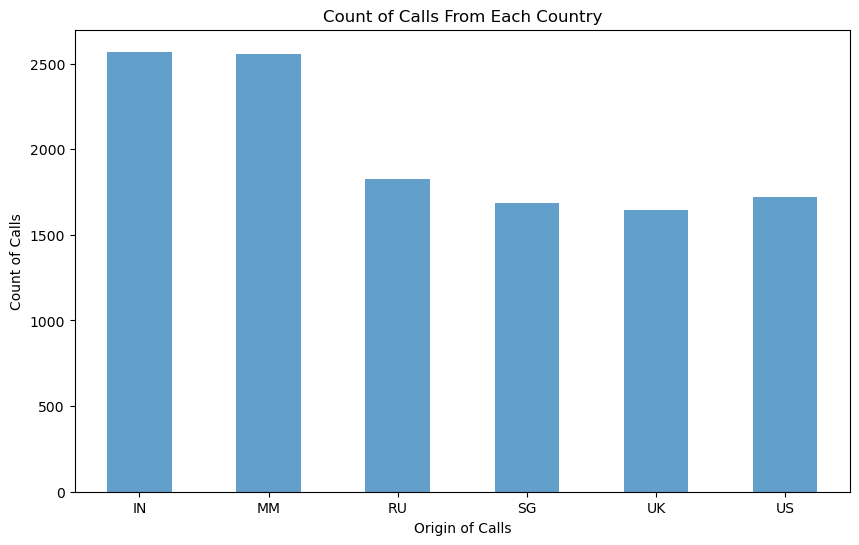

In [33]:
cp_counts = df_cp_onehot.sum()

# Plot the counts
plt.figure(figsize=(10, 6))  
cp_counts.plot(kind='bar', alpha=0.7)

plt.xlabel('Origin of Calls')
plt.ylabel('Count of Calls')
plt.title('Count of Calls From Each Country')
plt.xticks(rotation=0) 
plt.show()

Our dataset seems to contain a larger proportion of recorded calls from India and Myanmar. This is worth taking note of, especially when looking at the correlation later on. 

While we have also confirmed in this segment that all prefixes which are not '65' are correctly marked as international calls, the 'Is International' binary column does give us a slightly different possible implication with our label as compared to the relationship with individual origin countries as per our one-hot encoded 'Country Prefix'. 

### 8. Call Type
This column should contain categorical objects denoting the medium of the call. First, we will check what unique values we have in this column. 

In [34]:
# Converting all to lowercase
df['Call Type'] = df['Call Type'].str.lower()

unique_call_type = sorted(df['Call Type'].unique())

# Create a dictionary see all unique categories in 'Call Type'
call_type_dict = {i: call_type for i, call_type in enumerate(unique_call_type)}

print(call_type_dict)

{0: 'landline', 1: 'mobile', 2: 'telegram', 3: 'voip', 4: 'whats app', 5: 'whatsapp'}


Here we observe two different spellings for "WhatsApp" even though evidently they refer to the same medium. We fix this below by replacing all "Whats App" with "WhatsApp" such that the spelling is standardised. 

In [35]:
df['Call Type'] = df['Call Type'].replace('whats app', 'whatsapp')

# Check that all errors resolved
mis_spelled_rows = df[df['Call Type'].str.contains('whats app')].index.tolist()
print("Row numbers with mispelled 'Whats App':", mis_spelled_rows)

Row numbers with mispelled 'Whats App': []


As with other similar attribute types, we will cone-hot encode this into separate columns. 

In [36]:
df_ct_onehot = pd.get_dummies(df['Call Type'])
df_ct_onehot = df_ct_onehot.astype(int)
df_ct_onehot.head()

,landline,mobile,telegram,voip,whatsapp
0,0,0,0,1,0
1,0,1,0,0,0
2,0,0,0,1,0
3,0,0,1,0,0
4,0,0,1,0,0


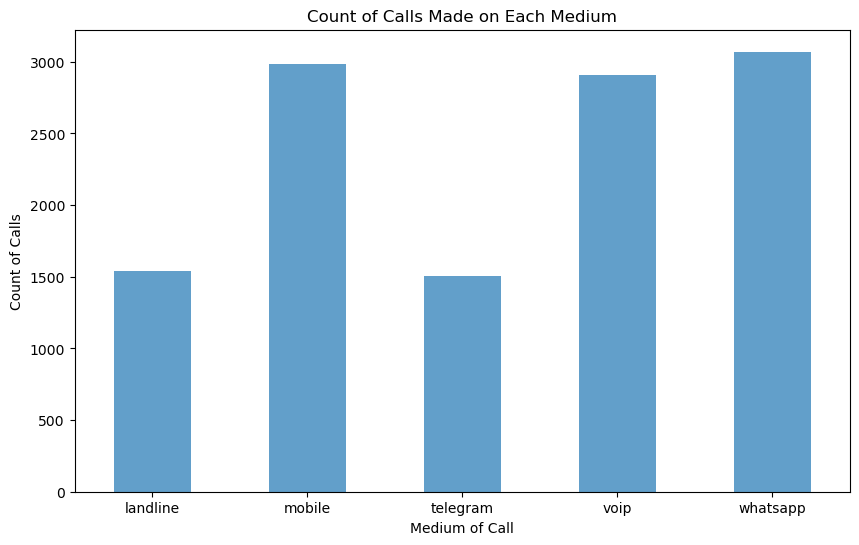

In [37]:
ct_counts = df_ct_onehot.sum()

# Plot the counts
plt.figure(figsize=(10, 6)) 
ct_counts.plot(kind='bar', alpha=0.7)

plt.xlabel('Medium of Call')
plt.ylabel('Count of Calls')
plt.title('Count of Calls Made on Each Medium')
plt.xticks(rotation=0) 
plt.show()

### 9. Timestamp
This column contains the timestamp of when the call was made. We are expecting the values to be formatted as YYYY-MM-DD hh:mm:ss. Here we run a check on the format to see if all values are formatted in the expected manner. Additionally, as the data spans across 2023 and 2024, we run an additional check to ensure that 29 Feb does not occur in 2023 as it was not a leap year. 

In [38]:
def check_datetime_format(df, column_name):
    invalid_rows = []
    try:
        # Attempt to parse each value in the column as a datetime object
        for idx, value in enumerate(df[column_name]):
            try:
                parsed_date = datetime.strptime(value, '%Y-%m-%d %H:%M:%S')
                # Check if year, month, day, hour, minute, and second values are valid
                if not (parsed_date.year == 2023 or 
                        parsed_date.year == 2024 and
                        1 <= parsed_date.month <= 12 and 
                        1 <= parsed_date.day <= 31 and 
                        0 <= parsed_date.hour <= 23 and
                        0 <= parsed_date.minute <= 59 and
                        0 <= parsed_date.second <= 59):
                    raise ValueError
            except ValueError:
                invalid_rows.append(idx)
                continue
        if not invalid_rows:
            print("All values are in the correct format: YYYY-MM-DD hh:mm:ss")
        else:
            print("The following row numbers have values not in the correct format:", invalid_rows)
    except Exception as e:
        print("An error occurred:", str(e))        

check_datetime_format(df, 'Timestamp')

All values are in the correct format: YYYY-MM-DD hh:mm:ss


In [39]:
def check_2023_feb_29(df, column_name):
    # Check if '2023-02-29' occurs in the date portion of the values in the column
    if any('2023-02-29' in value for value in df[column_name].str.split(' ')):
        row_ids = [index for index, value in enumerate(df[column_name].str.split(' ')) if '2023-02-29' in value]
        print("29 Feb occurred at row(s):", row_ids)

    else:
        print("29 Feb 2023 not found")


check_2023_feb_29(df, 'Timestamp')

29 Feb 2023 not found


Now that we know our 'Timestamp' values are in the correct format and do not contain leap year anomalies, we can process them in categories that are of meaning to us. We will organise the data into annual quarters for each year (i.e. q3 2023, q1 2024), months in each year (i.e. Jan 2023, Feb 2024), and time period of day (i.e. overnight, morning, afternoon, evening, night). Following which, we will one-hot encode each of these categories. 

In [40]:
# Convert 'Timestamp' values to the datetime format recognised by pd
df['Timestamp'] = pd.to_datetime(df['Timestamp'])

In [41]:
df['Annual Quarter'] = (
    'Q' + df['Timestamp'].dt.quarter.astype(str) + ' ' + df['Timestamp'].dt.year.astype(str)
)

In [42]:
df_aq_onehot = pd.get_dummies(df['Annual Quarter'])
df_aq_onehot = df_aq_onehot.astype(int)
df_aq_onehot.head()

,Q1 2023,Q1 2024,Q2 2023,Q3 2023,Q4 2023
0,0,0,0,1,0
1,0,0,0,1,0
2,0,0,0,0,1
3,1,0,0,0,0
4,0,0,0,0,1


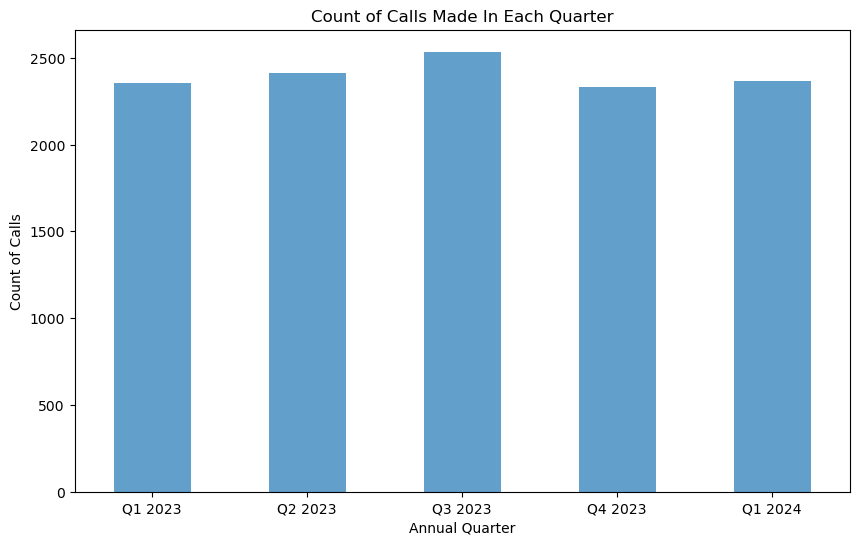

In [43]:
aq_counts = df_aq_onehot.sum()

aq_order=['Q1 2023', 'Q2 2023', 'Q3 2023', 'Q4 2023', 'Q1 2024']
aq_counts_ordered = aq_counts.reindex(aq_order)

# Plot the counts
plt.figure(figsize=(10, 6))
aq_counts_ordered.plot(kind='bar', alpha=0.7)

plt.xlabel('Annual Quarter')
plt.ylabel('Count of Calls')
plt.title('Count of Calls Made In Each Quarter')
plt.xticks(rotation=0) 
plt.show()

Our call count across the quarters look fairly evenly distributed. However we may need to dig deeper by looking at individual months. 

In [44]:
df['Month in Year'] = (
    df['Timestamp'].dt.strftime('%b') + ' ' + df['Timestamp'].dt.year.astype(str)
)

In [45]:
df_miy_onehot = pd.get_dummies(df['Month in Year'])
df_miy_onehot = df_miy_onehot.astype(int)
df_miy_onehot.head()

,Apr 2023,Aug 2023,Dec 2023,Feb 2023,Feb 2024,Jan 2023,Jan 2024,Jul 2023,Jun 2023,Mar 2023,Mar 2024,May 2023,Nov 2023,Oct 2023,Sep 2023
0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0


Apr 2023    756
Aug 2023    876
Dec 2023    754
Feb 2023    748
Feb 2024    790
Jan 2023    764
Jan 2024    763
Jul 2023    804
Jun 2023    771
Mar 2023    843
Mar 2024    812
May 2023    886
Nov 2023    774
Oct 2023    804
Sep 2023    855
dtype: int64


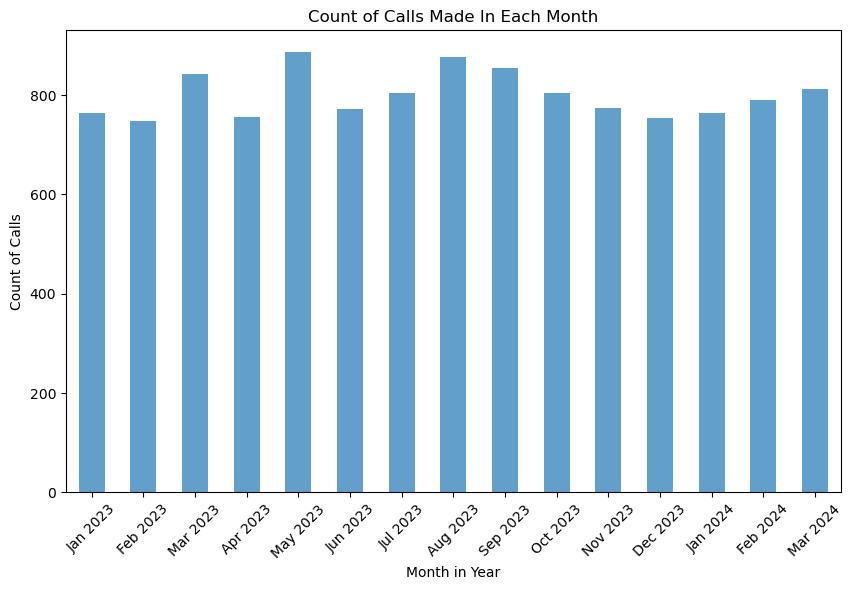

In [46]:
miy_counts = df_miy_onehot.sum()
print(miy_counts)

miy_order=['Jan 2023', 'Feb 2023', 'Mar 2023', 'Apr 2023', 'May 2023', 'Jun 2023', 
           'Jul 2023', 'Aug 2023', 'Sep 2023', 'Oct 2023', 'Nov 2023', 'Dec 2023', 
           'Jan 2024', 'Feb 2024', 'Mar 2024']
miy_counts_ordered = miy_counts.reindex(miy_order)

# Plot the counts
plt.figure(figsize=(10, 6))  
miy_counts_ordered.plot(kind='bar', alpha=0.7)

plt.xlabel('Month in Year')
plt.ylabel('Count of Calls')
plt.title('Count of Calls Made In Each Month')
plt.xticks(rotation=45) 
plt.show()

For both 'Annual Quarter' and 'Month in Year', as we only have about 1 and 1/4 of a year's worth of data, the size of the data set may not be large enough to spot seasonal patterns in scam calls. Breaking the dataset up by annual quarters lacks the fidelity as compared to when we categorise the dataset by months. 

We can also note a higher call traffic in certain months compared to others, which could mean certain biases in the data collection from month to month. For example, May 2023 seems to a higher amount of recorded call cases. Therefore this might skew our perspective of possibly having more scam calls in May 2023 when this might actually be due to a larger sample size in that month. Again, we will probably need a dataset that spans a longer time period in order to observe trends of biases due to seasonality. 

In [47]:
df['Time'] = df['Timestamp'].dt.time

# Define bins for different time of day categories
time_bins = [pd.to_timedelta('00:00:00').total_seconds(), pd.to_timedelta('06:00:00').total_seconds(),
             pd.to_timedelta('12:00:00').total_seconds(), pd.to_timedelta('17:00:00').total_seconds(),
             pd.to_timedelta('20:00:00').total_seconds(), pd.to_timedelta('24:00:00').total_seconds()]

# Define labels for time of day categories
time_labels = ['Overnight', 'Morning', 'Afternoon', 'Evening', 'Night']

# Calculate the time difference between each time value and midnight in seconds
midnight_seconds = pd.to_timedelta('00:00:00').total_seconds()
df['Time Diff'] = df['Timestamp'].apply(lambda x: (x.hour * 3600 + x.minute * 60 + x.second) - midnight_seconds)

# Bin the time differences into time of day categories
df['Time Binned'] = pd.cut(df['Time Diff'], bins=time_bins, labels=time_labels, right=False)

# Drop the intermediate columns if not needed
df = df.drop(columns=['Time', 'Time Diff'])

In [48]:
df_tb_onehot = pd.get_dummies(df['Time Binned'])
df_tb_onehot = df_tb_onehot.astype(int)
df_tb_onehot.head()

,Overnight,Morning,Afternoon,Evening,Night
0,0,1,0,0,0
1,0,0,0,0,1
2,0,1,0,0,0
3,0,1,0,0,0
4,0,0,1,0,0


Overnight    2488
Morning      3469
Afternoon    2301
Evening      1218
Night        2524
dtype: int64


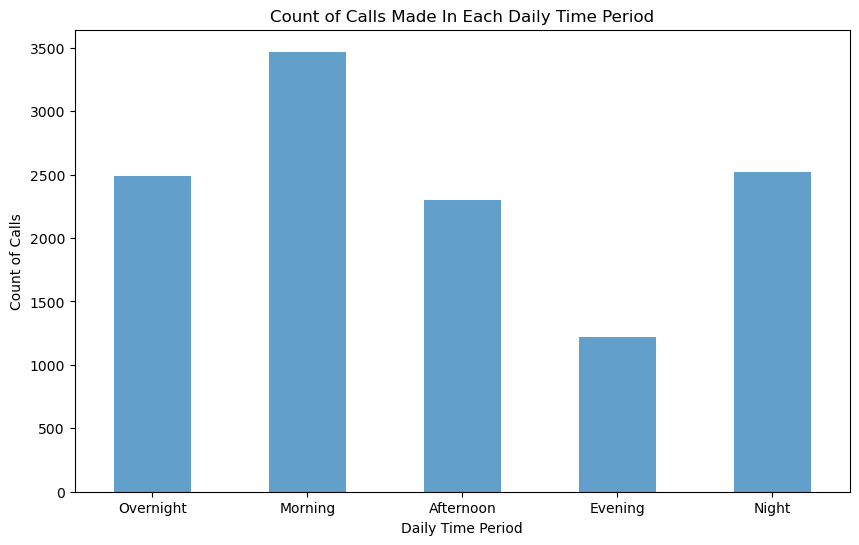

In [49]:
tb_counts = df_tb_onehot.sum()
print(tb_counts)

# Plot the counts
plt.figure(figsize=(10, 6)) 
tb_counts.plot(kind='bar', alpha=0.7)

plt.xlabel('Daily Time Period')
plt.ylabel('Count of Calls')
plt.title('Count of Calls Made In Each Daily Time Period')
plt.xticks(rotation=0) 
plt.show()

It seems that most calls occur/are recorded in the morning (0600h to 1200h) throughout our dataset. 

### 10. Device Battery
This column gives us information about the battery status of the caller's/potential scammer's device that was used to call the receiver. We should be expecting categorical objects. 

In [50]:
# Converting all to lowercase
df['Device Battery'] = df['Device Battery'].str.lower()

unique_dev_batt = sorted(df['Device Battery'].unique())

# Create a dictionary see all unique categories in 'Device Battery'
dev_batt_map = {dev_batt: i for i, dev_batt in enumerate(unique_dev_batt)}

print(dev_batt_map)

{'charging': 0, 'fully charged': 1, 'not charging': 2}


In [51]:
df_db_onehot = pd.get_dummies(df['Device Battery'])
df_db_onehot = df_db_onehot.astype(int)
df_db_onehot.head()

,charging,fully charged,not charging
0,0,1,0
1,0,1,0
2,1,0,0
3,0,1,0
4,0,1,0


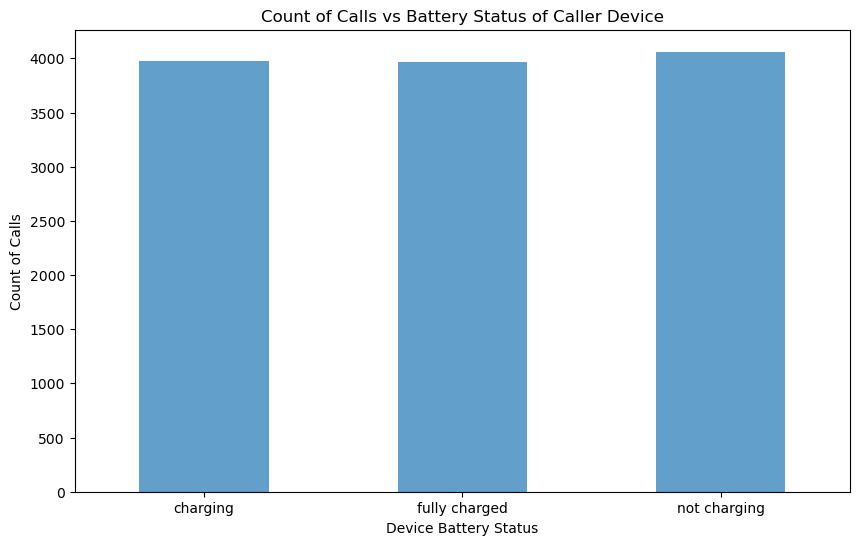

In [52]:
db_counts = df_db_onehot.sum()

# Plot the counts
plt.figure(figsize=(10, 6))  
db_counts.plot(kind='bar', alpha=0.7)

plt.xlabel('Device Battery Status')
plt.ylabel('Count of Calls')
plt.title('Count of Calls vs Battery Status of Caller Device')
plt.xticks(rotation=0)  
plt.show()

We have a relatively evenly distributed dataset across 'charging', 'fully charged', and 'not charging'. We have also converted the categories into numerical categories for our further analysis. 

### 11. Financial Loss
Our values in 'Financial Loss' are somewhat tricky to deal with. Firstly, we have to deal with the numerous negative values in the column. Secondly, we have to resolve the 1403 NaN values by replacing them with sensible values. 

We'll start by checking the count of negative values in 'Financial Loss'.

In [53]:
negative_count(df, 'Financial Loss')

Number of negative Financial Loss : 284


The 284 negative values make up a fairly small proportion of the total dataset and thus we can also assume that they may be due to typographical error. Given that we are trying to prevent/reduce the number of scams (by extrapolation the amount of money lost to scams), taking the abs() of the negative entries in the column can help give us a "worst case scenario" in that money was indeed lost in these cases. 

In [54]:
df['Financial Loss'] = df['Financial Loss'].abs()
negative_count(df, 'Financial Loss')

Number of negative Financial Loss : 0


Dealing with the NaN values may be slightly trickier. Simply filling in the NaN values with the mean will induce a bias of that column toward the mean which is unideal. Therefore a more complex way would be to incorporate our columns 'Timestamp' and 'Country Call Prefix' to get the average values of 'Financial Loss' categorised by month and country.

In [55]:
no_fl_no_scam = df['Financial Loss'].isna() & (df['Scam Call'] == 0)
no_fl_no_scam_no_flag = df['Financial Loss'].isna() & (df['Scam Call'] == 0) & (df['Flagged by Carrier'] == 0)

count_no_fl_no_scam = no_fl_no_scam.sum()
print("No. of NaN 'Financial Loss' values when call labelled 'Not Scam':", count_no_fl_no_scam)

count_no_fl_no_scam_no_flag = no_fl_no_scam_no_flag.sum()
print("No. of NaN 'Financial Loss' values when call labelled 'Not Scam' and flagged as 'Unlikely':", count_no_fl_no_scam_no_flag)

No. of NaN 'Financial Loss' values when call labelled 'Not Scam': 1403
No. of NaN 'Financial Loss' values when call labelled 'Not Scam' and flagged as 'Unlikely': 1133


Interestingly enough, all 1403 NaN values are coincident with when 'Scam Call' is labelled as 'Not Scam'. However, only 141 NaN values are coincident with when we add the condition of 'Flagged by Carrier' is 'Unlikely'. 

Considering that there may be cases whereby mislabelling has occured, we will take a conservative approach of replacing the NaN values of rows marked as 'Not Scam' and flagged as 'Unlikely' to be 0 in the 'Financial Loss' column. 

For the remainder of the NaN values, we will replace them with the mean financial losses according to annual quarters and origin country of the call. This should give us a less biased replacing of values that is in accordance with the dataset over the given time period. 

In [56]:
# Define conditions for calculating group-wise means
conditions = (df['Flagged by Carrier'].isin([1, 2])) & (df['Scam Call'] == 1)

# Calculate group-wise means based on the specified conditions
group_means = df[conditions].groupby(['Country Prefix', 'Month in Year'])['Financial Loss'].transform('mean')

# Create a boolean mask for null values in the 'Financial Loss' column
null_mask = df['Financial Loss'].isna()

# Fill null values in 'Financial Loss' column with group-wise means
df.loc[null_mask & conditions, 'Financial Loss'] = group_means[null_mask & conditions]

# Fill remaining null values with 0
df['Financial Loss'].fillna(0, inplace=True)

In [57]:
df['Financial Loss'].isnull().sum()

0

#### Check on 'Scam Call' column
We want to get a rough idea of how coincidental the labelling of the scam calls is with the 'Financial Loss' column. This is significant because the nature of the problem involves customers receiving scam calls resulting in a loss of money.

In [58]:
def check_scam_financial_loss_condition(df, col_1, col_2):
    no_scam_loss_rows = []
    scam_no_loss_rows = []
    for idx, row in df.iterrows():
        if row[col_1] == 0 and row[col_2] > 0:
            no_scam_loss_rows.append(idx)
        elif row[col_1] == 1 and row[col_2] == 0:
            scam_no_loss_rows.append(idx)
    if not no_scam_loss_rows and not scam_no_loss_rows :
        print("'Scam' label tallies with financial loss")
    else:
        print("'Not Scam' but financial loss reported:", len(no_scam_loss_rows))
        print("'Scam' but no financial loss reported:", len(scam_no_loss_rows))

check_scam_financial_loss_condition(df, 'Scam Call', 'Financial Loss')

'Not Scam' but financial loss reported: 3014
'Scam' but no financial loss reported: 1456


Interestingly enough, we have 3014 cases that are labelled as 'Not Scam' but still have a financial loss associated to said cases. A possible reasoning could be mislabelling of the scam vs not scam attribute, or that a financial loss was incurred but the said call was not the 'culprit'. 

On the flipside, we have 1456 calls that were labelled as 'Scam' but no financial loss was incurred. This could be possible in that the receiver accepted the call, realised the call was a scam call and fortunately did not fall for the scam but flagged the case nonetheless. Going by this assumption, we will accept these cases. 

### 13. Final Dataframe Cleanup
Here we will incorporate the processed dataframes into one consolidated dataframe and drop the columns that we no longer need. 

In [59]:
df.head()

,ID,Call Duration,Call Frequency,Financial Loss,Flagged by Carrier,Is International,Previous Contact Count,Country Prefix,Call Type,Timestamp,Device Battery,Scam Call,Call Duration Category,Call Duration Category Numerical,Call Frequency Category,Call Frequency Category Numerical,Previous Contact Count Normalised,Annual Quarter,Month in Year,Time Binned
0,947429,719,12,42.130000,1,1,1,MM,voip,2023-07-23 09:04:00,fully charged,1,"(600, 900]",0,"(10, 20]",0,0.125,Q3 2023,Jul 2023,Morning
1,540498,116,3,29.900000,0,1,0,IN,mobile,2023-09-05 20:11:00,fully charged,1,"(0, 300]",1,"(0, 10]",1,0.000,Q3 2023,Sep 2023,Night
2,434243,29,16,723.460000,2,1,2,IN,voip,2023-12-16 11:03:00,charging,1,"(0, 300]",1,"(10, 20]",0,0.250,Q4 2023,Dec 2023,Morning
3,903537,563,4,64.287478,0,1,3,IN,telegram,2023-02-25 10:41:00,fully charged,0,"(300, 600]",2,"(0, 10]",1,0.375,Q1 2023,Feb 2023,Morning
4,969179,312,19,0.000000,0,1,0,IN,telegram,2023-11-10 15:53:00,fully charged,1,"(300, 600]",2,"(10, 20]",0,0.000,Q4 2023,Nov 2023,Afternoon


Here we add in all of the one-hot encoded columns from the earlier segments. 

In [60]:
df = pd.concat([df, df_cp_onehot, df_ct_onehot, df_miy_onehot, df_tb_onehot, df_db_onehot], axis=1)

df.head()

,ID,Call Duration,Call Frequency,Financial Loss,Flagged by Carrier,Is International,Previous Contact Count,Country Prefix,Call Type,Timestamp,...,Oct 2023,Sep 2023,Overnight,Morning,Afternoon,Evening,Night,charging,fully charged,not charging
0,947429,719,12,42.130000,1,1,1,MM,voip,2023-07-23 09:04:00,...,0,0,0,1,0,0,0,0,1,0
1,540498,116,3,29.900000,0,1,0,IN,mobile,2023-09-05 20:11:00,...,0,1,0,0,0,0,1,0,1,0
2,434243,29,16,723.460000,2,1,2,IN,voip,2023-12-16 11:03:00,...,0,0,0,1,0,0,0,1,0,0
3,903537,563,4,64.287478,0,1,3,IN,telegram,2023-02-25 10:41:00,...,0,0,0,1,0,0,0,0,1,0
4,969179,312,19,0.000000,0,1,0,IN,telegram,2023-11-10 15:53:00,...,0,0,0,0,1,0,0,0,1,0


We will now drop the intermediary columns that were used as part of our data cleaning and transforming. 

We will also remove the 'Financial Loss' column from our dataframe as we move on toward correlation and evaluating our models. This is because as with the problem statement, financial losses incurred are a result of scam calls occuring. This means that this attribute is probably related to 'Scam Call' in a way that is more resultant rather than predictive. Furthermore, given that the intention is to send out a preventive SMS to the user before the scam occurs (and finances are stolen), it might be a good idea to remove this feature from the training dataset as it could skew our models in a flawed direction. 

In [61]:
columns_to_drop = ['ID', 'Call Duration', 'Call Frequency', 'Financial Loss', 'Previous Contact Count', 'Country Prefix', 
                   'Call Type', 'Timestamp', 'Device Battery', 'Call Duration Category', 'Call Frequency Category', 
                   'Annual Quarter', 'Month in Year', 'Time Binned']

df.drop(columns=columns_to_drop, inplace=True)

In [62]:
df.head()

,Flagged by Carrier,Is International,Scam Call,Call Duration Category Numerical,Call Frequency Category Numerical,Previous Contact Count Normalised,IN,MM,RU,SG,...,Oct 2023,Sep 2023,Overnight,Morning,Afternoon,Evening,Night,charging,fully charged,not charging
0,1,1,1,0,0,0.125,0,1,0,0,...,0,0,0,1,0,0,0,0,1,0
1,0,1,1,1,1,0.000,1,0,0,0,...,0,1,0,0,0,0,1,0,1,0
2,2,1,1,1,0,0.250,1,0,0,0,...,0,0,0,1,0,0,0,1,0,0
3,0,1,0,2,1,0.375,1,0,0,0,...,0,0,0,1,0,0,0,0,1,0
4,0,1,1,2,0,0.000,1,0,0,0,...,0,0,0,0,1,0,0,0,1,0


## Correlation
After assessing and cleaning our data, we are now ready to run some correlation tests. 

In [63]:
df.corr()

,Flagged by Carrier,Is International,Scam Call,Call Duration Category Numerical,Call Frequency Category Numerical,Previous Contact Count Normalised,IN,MM,RU,SG,...,Oct 2023,Sep 2023,Overnight,Morning,Afternoon,Evening,Night,charging,fully charged,not charging
Flagged by Carrier,1.000000,-0.010332,0.165220,0.000083,0.017040,0.029339,-0.008454,0.018241,-0.005134,-0.005366,...,-0.003272,0.003467,-0.103830,0.107356,-0.120373,-0.087379,0.164889,0.001867,0.003075,-0.004913
Is International,-0.010332,1.000000,0.067955,-0.007333,0.016436,-0.003355,0.143556,0.143129,0.116601,-0.681007,...,-0.009713,0.015373,0.020892,-0.007199,-0.006757,-0.012231,0.002816,-0.016170,0.012287,0.003873
Scam Call,0.165220,0.067955,1.000000,-0.002361,0.048843,-0.082282,0.096833,0.232032,-0.107695,-0.071831,...,-0.010961,0.016248,-0.050994,0.039485,-0.048443,-0.031009,0.076575,-0.001506,-0.003409,0.004886
Call Duration Category Numerical,0.000083,-0.007333,-0.002361,1.000000,0.009320,0.005085,-0.002158,0.004022,-0.014036,0.007841,...,-0.002119,-0.003108,0.014291,-0.017294,0.000462,0.000174,0.004447,-0.005269,0.015180,-0.009846
Call Frequency Category Numerical,0.017040,0.016436,0.048843,0.009320,1.000000,0.000106,0.019698,-0.005562,0.000880,-0.009591,...,-0.004661,-0.009549,0.006276,0.020028,-0.019968,-0.006016,-0.004775,0.004337,-0.004409,0.000068
Previous Contact Count Normalised,0.029339,-0.003355,-0.082282,0.005085,0.000106,1.000000,-0.011893,0.007493,-0.001473,0.009606,...,0.005027,0.007286,-0.017885,0.009436,-0.004262,-0.007644,0.017076,-0.018153,-0.000683,0.018737
IN,-0.008454,0.143556,0.096833,-0.002158,0.019698,-0.011893,1.000000,-0.271590,-0.221252,-0.210799,...,-0.019602,0.011024,0.002686,0.024803,-0.015278,0.002857,-0.017620,0.001642,-0.005794,0.004125
MM,0.018241,0.143129,0.232032,0.004022,-0.005562,0.007493,-0.271590,1.000000,-0.220595,-0.210172,...,0.002182,-0.009641,0.023518,-0.021182,-0.015149,-0.004404,0.018065,0.000770,0.006729,-0.007454
RU,-0.005134,0.116601,-0.107695,-0.014036,0.000880,-0.001473,-0.221252,-0.220595,1.000000,-0.171218,...,0.006051,0.006090,-0.006296,0.001819,0.020901,-0.013471,-0.005969,-0.024968,0.019873,0.005085
SG,-0.005366,-0.681007,-0.071831,0.007841,-0.009591,0.009606,-0.210799,-0.210172,-0.171218,1.000000,...,0.000229,-0.012980,-0.026012,-0.005573,0.026996,0.000139,0.005894,0.017522,-0.017763,0.000226


<Axes: >

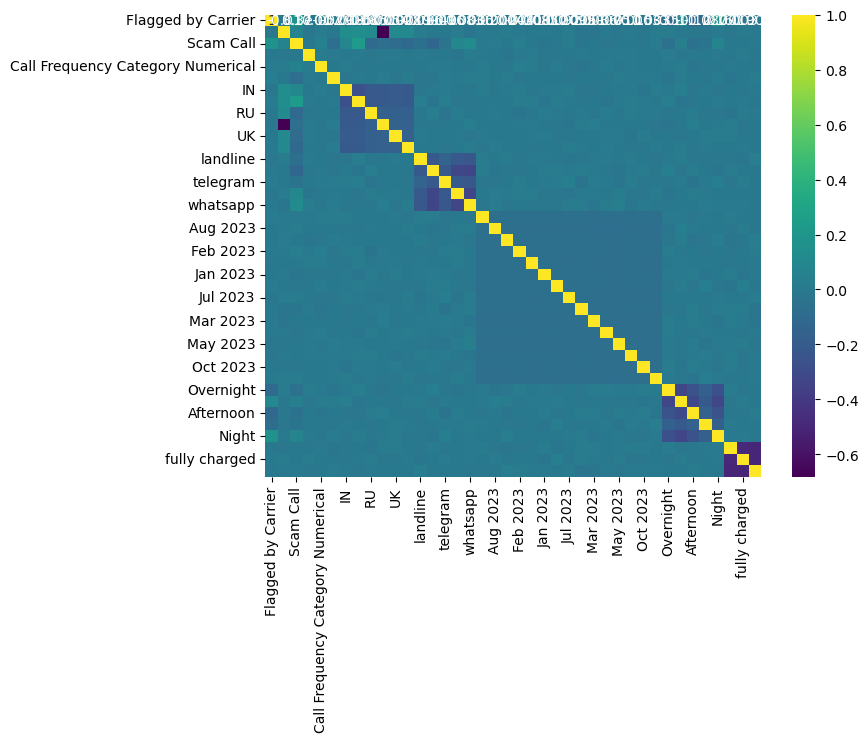

In [64]:
plt.figure(figsize=(8,6))

sns.heatmap(df.corr(), annot=True, cmap = 'viridis')

## Machine Learning Models
Now that we have identified certain correlations that exist in our dataset, we can now start assessing which ML models might work for our problem. First we will establish the training and test split. We shall use 20% of the data as the test set. 

In [65]:
train, test = train_test_split(df, test_size=0.2)

As 'Scam Call' is our label in this case, we will drop it from the features in X training and test set. We will form our Y training set from the 'Scam Call' column. 

In [66]:
X_train = train.drop('Scam Call', axis=1)
Y_train = train['Scam Call']
X_test = test.drop('Scam Call',axis=1).copy()

X_train

,Flagged by Carrier,Is International,Call Duration Category Numerical,Call Frequency Category Numerical,Previous Contact Count Normalised,IN,MM,RU,SG,UK,...,Oct 2023,Sep 2023,Overnight,Morning,Afternoon,Evening,Night,charging,fully charged,not charging
10001,0,1,1,1,0.000,1,0,0,0,0,...,0,0,1,0,0,0,0,0,1,0
2692,0,1,1,1,0.500,0,1,0,0,0,...,0,0,0,1,0,0,0,1,0,0
7033,1,1,2,1,0.125,0,0,0,0,0,...,0,0,0,1,0,0,0,0,1,0
3213,1,1,1,0,0.000,0,0,0,0,1,...,0,0,0,0,1,0,0,1,0,0
7446,0,1,1,0,0.125,0,1,0,0,0,...,0,0,0,1,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6734,0,1,1,1,0.125,0,0,0,0,1,...,0,0,0,1,0,0,0,0,0,1
6944,0,1,2,2,0.125,0,0,0,0,1,...,0,0,0,0,0,0,1,0,1,0
6745,0,1,1,1,0.375,0,0,0,0,1,...,0,0,0,0,0,0,1,0,1,0
11247,0,1,1,0,0.375,0,0,0,0,0,...,0,0,0,0,0,0,1,1,0,0


### Selecting Model Types
Our label that we aim to predict is of a binary classification nature. This gives us a few options of models that we can evaluate. For this type of application we have chosen to run our data through the following: 
1. Random Forests
2. Decision Trees
3. k-Nearest Neighbour
4. Stochastic Gradient Descent
5. Logistic Regression
6. Support Vector Machine
7. Gaussian Naive Bayes

After some hyperparameter tweaking through trial and error, we arrive at the respective hyperparameter tunings as shown in each model below. 

### 1. Random Forests

In [67]:
randomForest = RandomForestClassifier(n_estimators=75)
randomForest.fit(X_train, Y_train)

Y_prediction = randomForest.predict(X_test)

accuracy_randomForest = round(randomForest.score(X_train, Y_train) * 100, 2)

### 2. Decision Trees

In [68]:
tree = DecisionTreeClassifier() 
tree.fit(X_train, Y_train)  

Y_prediction = tree.predict(X_test)  

accuracy_tree = round(tree.score(X_train, Y_train) * 100, 2)

### 3. k-Nearest Neighbour

In [69]:
knn = KNeighborsClassifier(n_neighbors = 5) 
knn.fit(X_train, Y_train)  

Y_prediction = knn.predict(X_test)

accuracy_knn = round(knn.score(X_train, Y_train) * 100, 2)

### 4. Stochastic Gradient Descent

In [70]:
sgd = linear_model.SGDClassifier(max_iter=500, tol=0.1)
sgd.fit(X_train, Y_train)

Y_prediction = sgd.predict(X_test)

accuracy_sgd = round(sgd.score(X_train, Y_train) * 100, 2)

### 5. Logistic Regression

In [71]:
logreg = LogisticRegression(max_iter=1200)
logreg.fit(X_train, Y_train)

Y_prediction = logreg.predict(X_test)

accuracy_LogReg = round(logreg.score(X_train, Y_train) * 100, 2)

### 6. Support Vector Machine

In [72]:
svc = SVC(kernel='rbf', C=1.0, gamma='scale')
svc.fit(X_train, Y_train)

Y_prediction = svc.predict(X_test)

accuracy_svc = round(svc.score(X_train, Y_train) * 100, 2)

### 7. Gaussian Naive Bayes

In [73]:
naiveBayes = GaussianNB() 
naiveBayes.fit(X_train, Y_train)

Y_prediction = naiveBayes.predict(X_test)  

accuracy_naiveBayes = round(naiveBayes.score(X_train, Y_train) * 100, 2)

## Evaluation of ML models
Let's compare the accuracies of the models we have tried. 

In [74]:
results = pd.DataFrame({
    'Model': ['Random Forests', 'Decision Trees', 'k-Nearest Neighbour', 'Stochastic Gradient Descent', 'Logistic Regression', 'Support Vector Machine', 'Gaussian Naive Bayes'],
    'Score': [accuracy_randomForest, accuracy_tree, accuracy_knn, accuracy_sgd, accuracy_LogReg, accuracy_svc, accuracy_naiveBayes]
    })

results = results.sort_values(by='Score', ascending=False)
results = results.set_index('Score')
results.head(7)

,Model
Score,
99.35,Random Forests
99.35,Decision Trees
80.40,k-Nearest Neighbour
77.24,Support Vector Machine
68.45,Logistic Regression
67.40,Stochastic Gradient Descent
67.35,Gaussian Naive Bayes


The accuracy comparison shows us that two models score the best compared to the rest - Random Forests and Decision Trees. We will further assess these two models using a confusion matrix further on. 

## Feature Importance
Let's use Sklearn's in-built feature to compute the breakdown of relative feature importances. This should give us an overview of the importance of each feature. 

In [75]:
importances = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': np.round(randomForest.feature_importances_,3)
})
importances = importances.sort_values('Importance',ascending=False).set_index('Feature')
importances.head(15)

,Importance
Feature,
Previous Contact Count Normalised,0.125
Call Frequency Category Numerical,0.070
Flagged by Carrier,0.066
Call Duration Category Numerical,0.057
MM,0.048
not charging,0.030
fully charged,0.028
charging,0.028
Morning,0.027


<Axes: xlabel='Feature'>

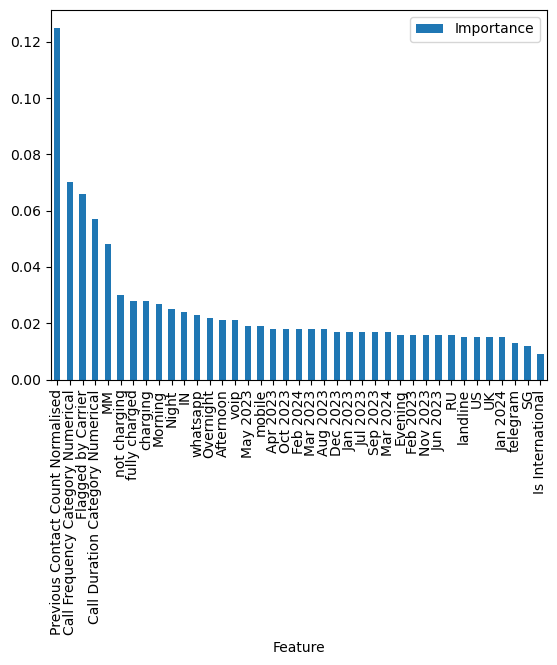

In [76]:
importances.plot.bar()

We observe that the top three features in terms of importance are 'Previous Contact Count Normalised', 'Call Frequency Category Numerical', and 'Flagged by Carrier'. Once again, we have to be wary that 'Flagged by Carrier' comes with possible biases as it is the result of a scam identification system that we do not have further information on. 

### Confusion Matrix
As above, we have established that the two models that seem to work the best are the Random Forests and Decision Tree models. Now we will compared how they perform through a confusion matrix for each model. This will give us a better idea of the errors involved in each model, and therefore which might be the better model to develop. 

In [77]:
rf_predictions = cross_val_predict(randomForest, X_train, Y_train, cv=3)
print('Random Forest Confusion Matrix:')
confusion_matrix(Y_train, rf_predictions)

Random Forest Confusion Matrix:


array([[4980, 1053],
       [1443, 2124]], dtype=int64)

In [78]:
dt_predictions = cross_val_predict(tree, X_train, Y_train, cv=3)
print('Decision Tree Confusion Matrix:')
confusion_matrix(Y_train, dt_predictions)

Decision Tree Confusion Matrix:


array([[4612, 1421],
       [1431, 2136]], dtype=int64)

Comparing the two confusion matrices, we can see that there are clear differences between the two models, even though their accuracy is very similar. The Random Forests model seems to perform better at True Negative and False Positives than the Decision Tree model. This means that the Random Forests model was able to correctly identify roughly 5000 non-scams of the 9600 cases in the training set. However, we have to note that Random Forests underperformed in identifying legitimate scam cases compared to the Decision Tree model. 

### Precision and Recall
We compare the two model's precisions and recalls below to further aid us in making a decision. 

In [79]:
print("Random Forests Precision:", precision_score(Y_train, rf_predictions))
print("Random Forests Recall:", recall_score(Y_train, rf_predictions))

print("\nDecision Tree Precision:", precision_score(Y_train, dt_predictions))
print("Decision Tree Recall:", recall_score(Y_train, dt_predictions))

Random Forests Precision: 0.6685552407932012
Random Forests Recall: 0.5954583683767872

Decision Tree Precision: 0.6005060444194545
Decision Tree Recall: 0.5988225399495374


As we can see, the Random Forests model has a higher precision (approx. 0.667) compared to that of the Decision Tree model (approx. 0.600). On the flipside, the Random Forests model has a lower recall (approx. 0.595) compared to the recall of the Decision Tree model (approx. 0.598). 

### Performance of Carrier's Existing Scam Detection Method
Recall that our 'Flagged by Carrier' column contains information from the carrier on whether a call is deemed to be suspicious or not. We will produce the confusion matrix, the precision and recall of the carrier's methods to compare our models to. This is assuming that the threshold for identifying a call as a scam is set at 'Suspicious', meaning to say that both 'Suspicious' and 'Very suspicious' will mark the call as a scam. 

In [80]:
def scam_and_flagged(flag_by_carrier, scam_call):
    if (flag_by_carrier in [1, 2]) and (scam_call == 1):
        return 'True Positive'
    elif (flag_by_carrier == 0) and (scam_call == 0):
        return 'True Negative'
    elif (flag_by_carrier in [1, 2]) and (scam_call == 0):
        return 'False Negative'
    elif (flag_by_carrier == 0) and (scam_call == 1):
        return 'False Positive'
    else:
        return 'Other'

# Apply the function to create a new column with categories
df_carrier_method = df.apply(lambda row: scam_and_flagged(row['Flagged by Carrier'], row['Scam Call']), axis=1)

# Count the occurrences of each category
confusion_matrix_counts = df_carrier_method.value_counts()

# Extract counts for each category
true_negative_count = confusion_matrix_counts.get('True Negative', 0)
false_positive_count = confusion_matrix_counts.get('False Positive', 0)
false_negative_count = confusion_matrix_counts.get('False Negative', 0)
true_positive_count = confusion_matrix_counts.get('True Positive', 0)

# Create the confusion matrix as a NumPy array
confusion_matrix_array = np.array([[true_negative_count, false_positive_count],
                                   [false_negative_count, true_positive_count]], dtype=np.int64)

# Display the confusion matrix array
print("Carrier Method Confusion Matrix: \n", confusion_matrix_array)

carrier_precision = true_positive_count/(true_positive_count + false_positive_count)
carrier_recall = true_positive_count/(true_positive_count + false_negative_count)

print("Carrier Method Precision: ", carrier_precision)
print("Carrier Method Recall: ", carrier_recall)

Carrier Method Confusion Matrix: 
 [[6224 2880]
 [1330 1566]]
Carrier Method Precision:  0.3522267206477733
Carrier Method Recall:  0.5407458563535912


At this point we can also verify through our precisions and recalls that both models perform better than the carrier's current methods of scam detection. Therefore developing an ML model to improve on current methods seems to be in the correct direction in our endeavour to reduce scam calls. 

### F-Score
Let's look at the F-scores of both models to see which performs better, given that the performance of both models has been fairly close. The F-score is the harmonic mean of the precision and recall, the closer the F-score is to 1.0, the better the performance of the model. 

In [81]:
print("Random Forests F-Score: ", f1_score(Y_train, rf_predictions))
print("Decision Tree F-Score: ", f1_score(Y_train, dt_predictions))

Random Forests F-Score:  0.6298932384341637
Decision Tree F-Score:  0.5996631106120157


Here we observe that the Random Forest model has a higher F-score at  approx. 0.61. Given that it is the model that seems to work better, we will select the Random Forests model as the basis for our ML model. Random Forest works as a classifier which should suffice in our case as we aim to predict between two categories. 

Do note that for our MLP we will include the Decision Tree model as an alternative option, even though our results have found the Random Forest model more favourable.

## Conclusion
Upon cleaning and processing our dataset, we identified certain attributes that do not bear a predictive relationship to our label (i.e. 'Financial Loss'), and others that help us identify possible biases in the dataset (i.e. 'Timestamp'). Putting into context the relationship between our various attributes allowed us to better formulate an approach toward evaluating and selecting our model. 

Using the Random Forest model, we are able to build upon a model that performs better than current existing scam prevention methods by the carrier. Our predictive model fits into the larger picture as a trigger to send out a warning SMS to the user upon the detection of a possible scam. In an ideal scenario, we would like our model to be able to predict a scam call highly accurately and prevent the highest amount of scam calls. However, considering that the purpose is to flag out probable scam calls to the user, our model may not need to be as deterministic because ultimately the user will be the decision maker on whether to end the call or not. 

Relating this analysis back to current scam call technology, scammers these days are able to use spoof numbers or mask their country prefixes, especially using VoIP. Tying this back to our dataset, it could mean that further development on such a model may have to incorporate other attributes instead of country prefix. 

## Resources
Listed below are some links used to contextualise the problem and the dataset:
1. https://www.channelnewsasia.com/singapore/paynow-scam-names-banks-information-fake-friend-experts-masking-4285146
2. https://www.comparitech.com/blog/information-security/number-spoofing-scams/
3. https://en.wikipedia.org/wiki/List_of_country_calling_codes
4. https://www.channelnewsasia.com/cnainsider/phone-scammers-exposed-web-deceit-across-region-scam-town-china-896961
5. https://www.mathworks.com/campaigns/offers/next/choosing-the-best-machine-learning-classification-model-and-avoiding-overfitting.html
6. https://www.kaggle.com/code/kkhandekar/top-10-algorithms-for-binary-classification